## Text Analysis Pipeline

Key Features in project:

1. **Text Classification**: We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).
2. **Entity Extraction**: We'll identify and extract key entities such as persons, organizations, and locations from the text.
3. **Text Summarization**: Finally, we'll generate a concise summary of the input text.


In [ ]:
# Installation of Langraph and integrate with LLM GEMINI Model
%%capture --no-stderr
%pip install -q -U langchain langchain-google-genai langgraph

### Set Up API Key
This cell loads environment variables and sets up the GEMINI API key and LLM Model as well.

In [ ]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=GEMINI_API_KEY,     # Provide the Google API key for authentication
)

## Building the Text Processing Pipeline

### Define State and Initialize LLM
Here we define the State class to hold our workflow data and initialize the GEMINI model.

In [ ]:
from typing_extensions import TypedDict
class TextAnaylsisState (TypedDict):
  text: str
  classification : str
  entities: str
  summary: str

In [ ]:
prompt: str = """
You are given a Text as input {text}.

You need to categorize the {text} into one domain NEWS, ARTICLE, BLOG.

Just return the Category i.e: for news classification then return NEWS.

text is: {text}
"""

In [ ]:
prompt.format(text="Hello")

'\nYou are given a Text as input Hello.\n\nYou need to categorize the Hello into one domain NEWS, ARTICLE, BLOG.\n\nJust return the Category i.e: for news classification then return NEWS.\n\ntext is: Hello\n'

### Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [ ]:
# Node 1: Classification Node
def classification_node(state: TextAnaylsisState) -> TextAnaylsisState:
  print('---Classification Node--',state)
  text : str = state['text']

  prompt : str = """
    You are given a Text as input.

    You need to categorize the text into one domain NEWS, ARTICLE, BLOG.

    Just return the Category i.e: for news classification then return NEWS.

    Text is: {text}

  """
  output = llm.invoke(prompt.format(text=text))
  print("---Output---", output.content)
  return {"classification" : output.content}



In [ ]:
sample_state : TextAnaylsisState = {
    "text" : "This is a sample text about a Article article."
}
node_1 = classification_node(sample_state)


---Classification Node-- {'text': 'This is a sample text about a Article article.'}
---Output--- ARTICLE 



In [ ]:
# Node 2: Entity Extraction Node
def Entity_extraction_node (state: TextAnaylsisState) -> TextAnaylsisState:
  print('---Entity_Extraction Node--', state)
  text : str = state['text']
  classification : str = state['classification']

  prompt : str = """
    You are given a Text as input.

    you have to extract the entities present in the text.
    Your job is to return just the names of the entities present in JSON i.e. {{"entities": ["Sir zia khan lives in Karachi"]}}

    Text is: {text}
    Classification is: {classification}
    JSON output format: {{"entities": ["1"...]}}

  """
  output = llm.invoke(prompt.format(text=text, classification=classification))
  print("---Output---", output.content)
  return {"entities" : output.content}

In [ ]:
## prompt: Run above entity_extraction with samples
sample_state: TextAnaylsisState = {
    "text": "This is a sample text about a news article.",
    "classification": "NEWS"
}

node_2_output = Entity_extraction_node(sample_state)
print(node_2_output)

---Entity_Extraction Node-- {'text': 'This is a sample text about a news article.', 'classification': 'NEWS'}
---Output--- ```json
{"entities": []}
```

The provided text "This is a sample text about a news article." does not contain any named entities like people, places, organizations, or dates. Therefore, the JSON output is an empty list. 

{'entities': '```json\n{"entities": []}\n```\n\nThe provided text "This is a sample text about a news article." does not contain any named entities like people, places, organizations, or dates. Therefore, the JSON output is an empty list. \n'}


In [ ]:
# Node 3: Text Summarization Node
def text_summary_node(state: TextAnaylsisState) -> TextAnaylsisState:
  print('---Text_Summary Node--', state)
  text : str = state['text']
  classification : str = state['classification']
  entities : str = state['entities']

  prompt : str = """
    You are given a Text as input.

    You have to generate the summary of the text in 100 words.

    Text is: {text}
    Classification is: {classification}
    Entities is: {entities}

  """
  output = llm.invoke(prompt.format(text=text, classification=classification, entities = entities))
  print("---Output---", output.content)
  return {"summary" : output.content}


In [ ]:
sample_state: TextAnaylsisState = {
    "text": "This is a sample text about a news article.",
    "classification": "NEWS",
    "entities": "['zia khan']"
}

node_3_output = text_summary_node(sample_state)
print(node_3_output)

---Text_Summary Node-- {'text': 'This is a sample text about a news article.', 'classification': 'NEWS', 'entities': "['zia khan']"}
---Output--- This is a news article about Zia Khan, a prominent figure mentioned in the text.  While the specific details of the article are not provided, the classification "NEWS" and the presence of an entity suggest a news story focused on Zia Khan.  The article likely discusses events, actions, or statements related to Zia Khan, making it a relevant news item for readers interested in this individual. 

{'summary': 'This is a news article about Zia Khan, a prominent figure mentioned in the text.  While the specific details of the article are not provided, the classification "NEWS" and the presence of an entity suggest a news story focused on Zia Khan.  The article likely discusses events, actions, or statements related to Zia Khan, making it a relevant news item for readers interested in this individual. \n'}


In [ ]:
!pip install -qU langgraph

### Create Tools and Build Workflow
This cell builds the StateGraph workflow.

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

text_pipeline_builder : StateGraph = StateGraph(TextAnaylsisState)

text_pipeline_builder.add_node("Classification", classification_node)
text_pipeline_builder.add_node("Entity_Extraction", Entity_extraction_node)
text_pipeline_builder.add_node("text_summary", text_summary_node)

## Create Edges

In [ ]:
text_pipeline_builder.add_edge(START, "Classification")
text_pipeline_builder.add_edge("Classification", "Entity_Extraction")
text_pipeline_builder.add_edge("Entity_Extraction", "text_summary")
text_pipeline_builder.add_edge( "text_summary", END)


text_pipline_complied_graph: CompiledStateGraph = text_pipeline_builder.compile()


## Visualize the Workflow


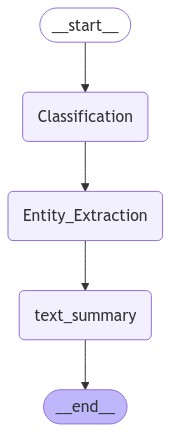

None


In [ ]:
from IPython.display import Image, display
graph : CompiledStateGraph = display(
            Image(
                text_pipline_complied_graph.get_graph().draw_mermaid_png()))
print(graph)

## Testing the Pipeline

In [ ]:
# Invoke the Graph
text = '''
Intelligent Agents (IA) are a fundamental concept in artificial intelligence that has gained immense popularity in various industries. An Intelligent Agent can be thought of as a software entity designed to perceive its environment and take actions that maximize its chances of successfully achieving a goal. Unlike simple automated programs, IA agents are built to learn, adapt, and operate autonomously, making them versatile and applicable to many real-world problems.

IA agents come in different forms, each with a specific set of capabilities that enable them to work effectively within their domains. One common example is the reactive agent, which bases its actions purely on the current state of its environment. This kind of agent does not store or process memories of past actions but instead reacts to changing stimuli directly. Simple rule-based bots used for navigating basic environments fall into this category.

In contrast, more sophisticated IA agents can maintain an internal state, allowing them to make decisions based not just on the present but also on past experiences. These agents are often termed deliberative agents, as they consider the implications of different choices over time to achieve their objectives. Deliberative agents use planning and optimization techniques to identify the sequence of actions that will lead to a desired outcome.

Another crucial category of IA agents is learning agents. These agents are capable of improving their behavior over time. A learning agent can modify its rules or policies based on feedback, allowing it to become more efficient in completing tasks. Machine learning algorithms, such as reinforcement learning, are often integrated into IA agents to help them learn from success or failure in their tasks. AlphaGo, a game-playing agent developed by DeepMind, is an excellent example of a learning agent that was able to outperform expert human players by continuously improving its strategies.

IA agents can also be multi-agent systems, where several agents collaborate or compete to accomplish goals. In multi-agent systems, agents can share information and coordinate their actions, leading to a collective intelligence capable of solving complex problems that would be too challenging for a single agent. For instance, self-driving cars in a smart transportation network can work together to prevent traffic congestion by communicating in real-time, adjusting their speeds, and choosing routes dynamically.
'''


In [ ]:
graph_output = text_pipline_complied_graph.invoke({"text": text})

---Classification Node-- {'text': '\nIntelligent Agents (IA) are a fundamental concept in artificial intelligence that has gained immense popularity in various industries. An Intelligent Agent can be thought of as a software entity designed to perceive its environment and take actions that maximize its chances of successfully achieving a goal. Unlike simple automated programs, IA agents are built to learn, adapt, and operate autonomously, making them versatile and applicable to many real-world problems.\n\nIA agents come in different forms, each with a specific set of capabilities that enable them to work effectively within their domains. One common example is the reactive agent, which bases its actions purely on the current state of its environment. This kind of agent does not store or process memories of past actions but instead reacts to changing stimuli directly. Simple rule-based bots used for navigating basic environments fall into this category.\n\nIn contrast, more sophisticate

In [ ]:
graph_output['classification']

'ARTICLE \n'

In [ ]:
graph_output['entities']

'```json\n{"entities": ["Intelligent Agents", "IA", "artificial intelligence", "reactive agent", "deliberative agents", "learning agents", "AlphaGo", "DeepMind", "multi-agent systems", "self-driving cars", "smart transportation network"]}\n``` \n'

In [ ]:
graph_output['summary']

'Intelligent Agents (IA) are software entities that can perceive their environment and act to achieve goals. Unlike simple programs, IAs learn, adapt, and operate autonomously, making them versatile for various applications.  Types of IAs include reactive agents, which react to the present, deliberative agents, which use past experiences to make decisions, and learning agents, which improve their behavior over time through feedback. Examples include AlphaGo, a game-playing agent that learned to outperform human players, and self-driving cars in a smart transportation network, which can collaborate to optimize traffic flow. \n'